# Chatbot with message summarization

## Review

We've covered how to customize graph state schema and reducer. 
 
We've also shown a number of ways to trim or filter messages in graph state. 

## Goals

Now, let's take it one step further! 

Rather than just trimming or filtering messages, we'll show how to use LLMs to produce a running summary of the conversation.
 
This allows us to retain a compressed representation of the full conversation, rather than just removing it with trimming or filtering.

We'll incorporate this summarization into a simple Chatbot.  

And we'll equip that Chatbot with memory, supporting long-running conversations without incurring high token cost / latency. 

In [3]:
import os
from dotenv import load_dotenv
load_dotenv()

True

We'll use [LangSmith](https://docs.langchain.com/langsmith/home) for  [tracing](https://docs.langchain.com/langsmith/observability-concepts).

In [18]:
# from langchain_openai import ChatOpenAI
# model = ChatOpenAI(model="gpt-3.5-turbo",temperature=0)

# from langchain_google_genai import ChatGoogleGenerativeAI
# model = ChatGoogleGenerativeAI(model="gemini-2.5-flash", temperature=0)

# from langchain_groq import ChatGroq
# model = ChatGroq(model="openai/gpt-oss-120b", temperature=0)

from langchain_deepseek import ChatDeepSeek
model = ChatDeepSeek(
    model="deepseek/deepseek-chat-v3.1",
    api_key=os.getenv("OPENROUTER_API_KEY"),
    api_base="https://openrouter.ai/api/v1",
    extra_body={"reasoning": {"enabled": True}},
)

We'll use `MessagesState`, as before.

In addition to the built-in `messages` key, we'll now include a custom key (`summary`).

In [19]:
from langgraph.graph import MessagesState
class State(MessagesState):
    summary: str

We'll define a node to call our LLM that incorporates a summary, if it exists, into the prompt.

In [20]:
from langchain_core.messages import SystemMessage, HumanMessage, RemoveMessage

# Define the logic to call the model
def call_model(state: State):
    
    # Get summary if it exists
    summary = state.get("summary", "")

    # If there is summary, then we add it
    if summary:
        
        # Add summary to system message
        system_message = f"Summary of conversation earlier: {summary}"

        # Append summary to any newer messages
        messages = [SystemMessage(content=system_message)] + state["messages"]
    
    else:
        messages = state["messages"]
    
    response = model.invoke(messages)
    return {"messages": response}

We'll define a node to produce a summary.

Note, here we'll use `RemoveMessage` to filter our state after we've produced the summary.

In [21]:
def summarize_conversation(state: State):
    
    # First, we get any existing summary
    summary = state.get("summary", "")

    # Create our summarization prompt 
    if summary:
        
        # A summary already exists
        summary_message = (
            f"This is summary of the conversation to date: {summary}\n\n"
            "Extend the summary by taking into account the new messages above:"
        )
        
    else:
        summary_message = "Create a summary of the conversation above:"

    # Add prompt to our history
    messages = state["messages"] + [HumanMessage(content=summary_message)]
    response = model.invoke(messages)
    
    # Delete all but the 2 most recent messages
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    return {"summary": response.content, "messages": delete_messages}

We'll add a conditional edge to determine whether to produce a summary based on the conversation length.

In [22]:
from langgraph.graph import END
from typing_extensions import Literal
# Determine whether to end or summarize the conversation
def should_continue(state: State) -> Literal ["summarize_conversation", END]:
    
    """Return the next node to execute."""
    
    messages = state["messages"]
    
    # If there are more than six messages, then we summarize the conversation
    if len(messages) > 6:
        return "summarize_conversation"
    
    # Otherwise we can just end
    return END

## Adding memory

Recall that [state is transient](https://github.com/langchain-ai/langgraph/discussions/352#discussioncomment-9291220) to a single graph execution.

This limits our ability to have multi-turn conversations with interruptions. 

As introduced at the end of Module 1, we can use [persistence](https://docs.langchain.com/oss/python/langgraph/persistence) to address this! 
 
LangGraph can use a checkpointer to automatically save the graph state after each step.

This built-in persistence layer provides memory, allowing LangGraph to resume from the last state update. 

As we previously showed, one of the easiest to work with is `MemorySaver`, an in-memory key-value store for Graph state.

All we need to do is compile the graph with a checkpointer, and our graph has memory!

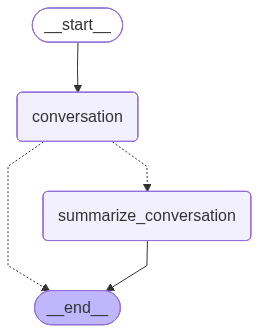

In [23]:
from IPython.display import Image, display
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START

# Define a new graph
workflow = StateGraph(State)
workflow.add_node("conversation", call_model)
workflow.add_node(summarize_conversation)

# Set the entrypoint as conversation
workflow.add_edge(START, "conversation")
workflow.add_conditional_edges("conversation", should_continue)
workflow.add_edge("summarize_conversation", END)

# Compile
memory = MemorySaver()
graph = workflow.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

## Threads

The checkpointer saves the state at each step as a checkpoint.

These saved checkpoints can be grouped into a `thread` of conversation.

Think about Slack as an analog: different channels carry different conversations.

Threads are like Slack channels, capturing grouped collections of state (e.g., conversation).

Below, we use `configurable` to set a thread ID.

![state.jpg](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbadf3b379c2ee621adfd1_chatbot-summarization1.png)

In [24]:
# Create a thread
config = {"configurable": {"thread_id": "1"}}

# Start conversation
input_message = HumanMessage(content="hi! I'm Paddy")
output = graph.invoke({"messages": [input_message]}, config) 
for m in output['messages'][-1:]:
    m.pretty_print()

input_message = HumanMessage(content="what's my name?")
output = graph.invoke({"messages": [input_message]}, config) 
for m in output['messages'][-1:]:
    m.pretty_print()

input_message = HumanMessage(content="i like the CSK!")
output = graph.invoke({"messages": [input_message]}, config) 
for m in output['messages'][-1:]:
    m.pretty_print()

================================== Ai Message ==================================

Hi Paddy! Nice to meet you. 😊 How can I help you today?
================================== Ai Message ==================================

Paddy! You introduced yourself earlier—it’s a pleasure to chat with you! 😊
================================== Ai Message ==================================

That's awesome! CSK (Chennai Super Kings) is one of the most loved teams in the Indian Premier League (IPL)! 🦁💛  
They've got a huge fan base and are known for their consistency, legendary players like MS Dhoni, and of course, those thrilling last-over finishes.  

Are you excited for the next season, or do you have a favorite CSK memory? 😊


Now, we don't yet have a summary of the state because we still have < = 6 messages.

This was set in `should_continue`. 

```
    # If there are more than six messages, then we summarize the conversation
    if len(messages) > 6:
        return "summarize_conversation"
```

We can pick up the conversation because we have the thread.

In [26]:
graph.get_state(config).values.get("summary","")

''

The `config` with thread ID allows us to proceed from the previously logged state!

In [27]:
input_message = HumanMessage(content="i like Jadeja. Is he the highest paid player?")
output = graph.invoke({"messages": [input_message]}, config) 
for m in output['messages'][-1:]:
    m.pretty_print()

================================== Ai Message ==================================

Great choice! Ravindra Jadeja is an incredible all-rounder and a key player for CSK. He's definitely one of the top earners on the team, but he isn't *the* highest-paid player in CSK.

As of the latest IPL season (2024), here's how it breaks down:

- **MS Dhoni** is the highest-paid player in CSK (even if he took a pay cut in recent years due to retention rules, his iconic status keeps him at the top in terms of value and influence).
- **Ravindra Jadeja** is among the top earners, along with players like **Deepak Chahar** and **Ruturaj Gaikwad**.

In terms of exact figures (for IPL 2024 retention):
- MS Dhoni: ₹12 crore  
- Ravindra Jadeja: ₹16 crore  
- Deepak Chahar: ₹14 crore

So actually, **Jadeja is paid more than Dhoni** in terms of salary! 🎉 That reflects his immense value as a world-class all-rounder.

Would you like to know more about his stats or his role in the team? 😊💛


In [28]:
graph.get_state(config).values.get("summary","")

"Sure! Here's a summary of our conversation:\n\n- You introduced yourself as **Paddy**.\n- You expressed that you're a fan of **CSK** (Chennai Super Kings) and specifically mentioned liking **Ravindra Jadeja**.\n- You asked if Jadeja is the **highest-paid player** in CSK.\n- I clarified that while Jadeja is one of the top earners (₹16 crore in IPL 2024), **MS Dhoni** (₹12 crore) holds iconic status, though Jadeja actually earns more in terms of salary.\n\nLet me know if you'd like more cricket or CSK-related info! 😊🏏"

## LangSmith

Let's review the trace!